In [101]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile as wav
%matplotlib inline
import numpy as np
import pandas as pd
import os
from pydub import AudioSegment
import matplotlib
import shutil

### Understanding Metadata


In [68]:
#loading maadata from csv file 
metadata = pd.read_csv('Audio_Data/BG_BR.csv')

#printing metadata 
metadata.head()

,slice_file_name,FSID,Maximum_Amplitude,Minimum_Amplitude,Start Time in original File(Sec),End Time in orignal File(Sec),Class ID,fold,class,Location on drive
0,Ball_Bounce_On_Ground.wav002_user.wav,211213,0.688888,-0.962503,[[ 21.5752381 404.8645805]],[[21.87519274]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
1,Ball_Bounce_On_Ground.wav003_user.wav,211213,0.669433,-0.694868,[[23.8215873]],[[24.12154195]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
2,Ball_Bounce_On_Ground.wav004_user.wav,211213,0.597916,-0.766195,[[24.99750567]],[[25.29746032]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
3,Ball_Bounce_On_Ground.wav005_user.wav,211213,0.552153,-0.623119,[[30.62698413]],[[30.92693878]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
4,Ball_Bounce_On_Ground.wav006_user.wav,211213,0.580958,-0.677036,[[38.69619048]],[[38.99614512]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...


In [69]:
#check for imbalance dataset
#if the difference in numbers of files is significant then our data will be consider as imbalanced data
metadata['class'].value_counts()

Ball Ground Hit    753
Ball Racket Hit    694
Name: class, dtype: int64

### Data Preprocessing 

In [70]:
#loading csv file 
audio_dataset_path = 'Audio_Data/Audio/'
metadata=pd.read_csv('Audio_Data/BG_BR.csv')
#printing metadata 
metadata.head()

,slice_file_name,FSID,Maximum_Amplitude,Minimum_Amplitude,Start Time in original File(Sec),End Time in orignal File(Sec),Class ID,fold,class,Location on drive
0,Ball_Bounce_On_Ground.wav002_user.wav,211213,0.688888,-0.962503,[[ 21.5752381 404.8645805]],[[21.87519274]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
1,Ball_Bounce_On_Ground.wav003_user.wav,211213,0.669433,-0.694868,[[23.8215873]],[[24.12154195]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
2,Ball_Bounce_On_Ground.wav004_user.wav,211213,0.597916,-0.766195,[[24.99750567]],[[25.29746032]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
3,Ball_Bounce_On_Ground.wav005_user.wav,211213,0.552153,-0.623119,[[30.62698413]],[[30.92693878]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...
4,Ball_Bounce_On_Ground.wav006_user.wav,211213,0.580958,-0.677036,[[38.69619048]],[[38.99614512]],2,1,Ball Ground Hit,C:/Users/Ankit Kumar/Audio_Data/BallBounceOnGr...


In [71]:
#the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.
# n_mfcc = number of MFCCs to return
#sr = sample rate, y =audio time series

def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc = 40)
    mfccs_scaled_features=np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


In [72]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'\\',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1447it [00:14, 100.71it/s]


In [73]:
#creating dataframe  from the list of etracted features
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

In [74]:
#printing dataframe and saving it into csv for better understanding
extracted_features_df.head()

,feature,class
0,"[-252.92578, 142.6328, -23.307566, 17.159676, ...",Ball Ground Hit
1,"[-270.47318, 151.5141, -31.51296, 22.09384, 13...",Ball Ground Hit
2,"[-263.1113, 145.61594, -30.467701, 20.84265, 1...",Ball Ground Hit
3,"[-270.6276, 146.31517, -32.099884, 19.047443, ...",Ball Ground Hit
4,"[-268.72382, 143.29037, -28.820272, 16.434462,...",Ball Ground Hit


In [75]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())

In [76]:
### Split the dataset into independent and dependent dataset
y = np.array(extracted_features_df['class'].tolist())

In [77]:
#Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. 
y=np.array(pd.get_dummies(y))

In [78]:
#spliting dataset into test and train data
#random state = 0 (random datasets would be taken each time we will run the program)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [79]:
#obtaining the shape of test and train datasets
X_train.shape
X_test.shape
y_train.shape
y_test.shape
print('X_shape: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)
#print(No of training dataset or testing data set,no of features or labels)

X_shape:  (1157, 40)
X_test:  (290, 40)
y_train:  (1157, 2)
y_test:  (290, 2)


## Model 

In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

In [81]:
num_labels=y.shape[1]
num_labels

2

In [82]:
#Creating model
#here we have used 100,200,100 nurons in different layers
#we have use relu activation function
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

In [83]:
#model summary for better understanding
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [84]:
#selecting loss function adn optimizer
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [85]:
## Trianing the model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 40

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
29/29 [==============================] - 1s 18ms/step - loss: 11.4250 - accuracy: 0.5730 - val_loss: 0.1405 - val_accuracy: 0.9724

Epoch 00001: val_loss improved from inf to 0.14049, saving model to saved_models\audio_classification.hdf5
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 4.3682 - accuracy: 0.6811 - val_loss: 0.1031 - val_accuracy: 0.9724

Epoch 00002: val_loss improved from 0.14049 to 0.10306, saving model to saved_models\audio_classification.hdf5
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 2.0738 - accuracy: 0.7666 - val_loss: 0.0891 - val_accuracy: 0.9828

Epoch 00003: val_loss improved from 0.10306 to 0.08912, saving model to saved_models\audio_classification.hdf5
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 1.1602 - accuracy: 0.8358 - val_loss: 0.0788 - val_accuracy: 0.9897

Epoch 00004: val_loss improved from 0.08912 to 0.07879, saving model to saved_models\audio_classifica

29/29 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.0486 - val_accuracy: 0.9966

Epoch 00039: val_loss did not improve from 0.04585
Epoch 40/100
29/29 [==============================] - 0s 8ms/step - loss: 0.0214 - accuracy: 0.9957 - val_loss: 0.0526 - val_accuracy: 0.9966

Epoch 00040: val_loss did not improve from 0.04585
Epoch 41/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0577 - val_accuracy: 0.9966

Epoch 00041: val_loss did not improve from 0.04585
Epoch 42/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0206 - accuracy: 0.9948 - val_loss: 0.0543 - val_accuracy: 0.9966

Epoch 00042: val_loss did not improve from 0.04585
Epoch 43/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0436 - val_accuracy: 0.9966

Epoch 00043: val_loss improved from 0.04585 to 0.04356, saving model to saved_models\audio_cla

29/29 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0659 - val_accuracy: 0.9966

Epoch 00080: val_loss did not improve from 0.04204
Epoch 81/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0587 - val_accuracy: 0.9966

Epoch 00081: val_loss did not improve from 0.04204
Epoch 82/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0551 - val_accuracy: 0.9966

Epoch 00082: val_loss did not improve from 0.04204
Epoch 83/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0671 - val_accuracy: 0.9966

Epoch 00083: val_loss did not improve from 0.04204
Epoch 84/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0669 - val_accuracy: 0.9966

Epoch 00084: val_loss did not improve from 0.04204
Epoch 85/100
29/29 [=======================

In [89]:
    filename= "C:/Users/Ankit Kumar/Audio_Data/Audio/Ball_Racket_Stairwell_01016_user.wav"

    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    #print(mfccs_scaled_features)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    #print(mfccs_scaled_features)
    #print(mfccs_scaled_features.shape)
    predicted_label=model.predict_classes(mfccs_scaled_features)
    print(predicted_label)
    
    # 1 for Ball_Racket
    # 0 for Ball_Ground

[1]


C:\Users\Ankit Kumar\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### Testing Model

In [90]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print('Accuracy is',test_accuracy[1])

Accuracy is 0.9965517520904541


### Computing instantaneous energy at $n^{th}$ sample as $\displaystyle \frac{x_n^2}{\sum\limits_k x_k^2}$

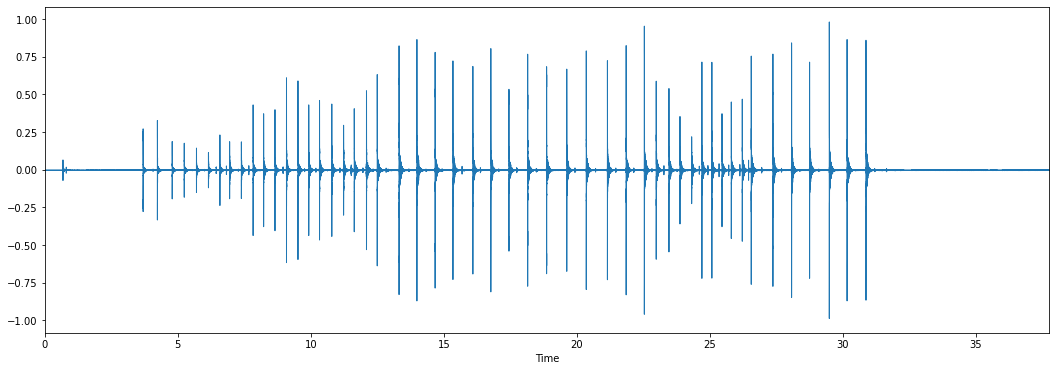

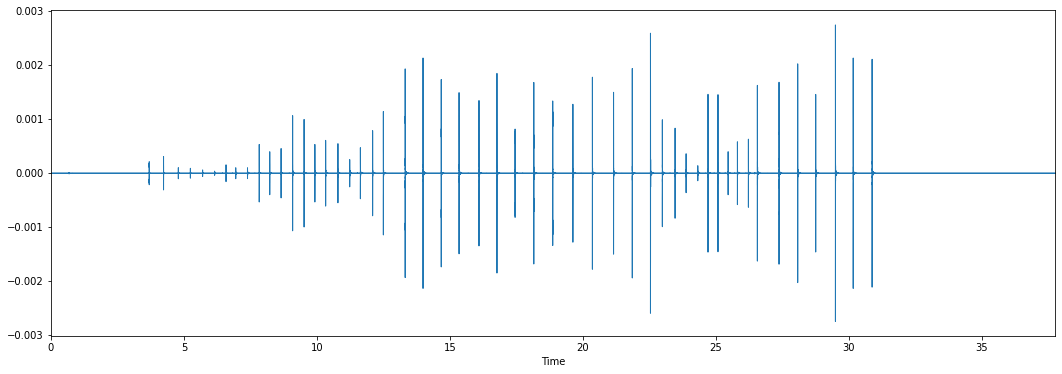

In [145]:
dataDir = 'C:/Users/Ankit Kumar/ball_floor_tile.wav '
nole_andy_rome, sr = librosa.load(dataDir)
fig, ax = plt.subplots(figsize=(18,6))
librosa.display.waveplot(nole_andy_rome, sr=sr,ax=ax)
nole_andy_rome_Energy = nole_andy_rome**2
nole_andy_rome_Energy = nole_andy_rome_Energy/nole_andy_rome_Energy.sum()
fig, ax = plt.subplots(figsize=(18,6))
librosa.display.waveplot(nole_andy_rome_Energy, sr=sr,ax=ax)
eventOnset =  librosa.onset.onset_detect(nole_andy_rome_Energy, sr=sr, units='time')
# I think librosa plots any waveform by subtracting out the average. Hence, energy also shows negative values. I could 
# have plotted using matplotlib, but librosa is much faster (at least I've noticed that)

In [146]:
for i in range(len(eventOnset)) :
    sound= AudioSegment.from_wav(dataDir)
    duration = sound.duration_seconds
    begin = eventOnset[i] - .5
    begin = begin*1000
    end = eventOnset[i] + .5
    end = end*1000
    cut_wav = sound[begin: end]
    cut_wav.export(f'newaudio{i}.wav', format="wav")

In [148]:


for k in range(len(eventOnset)):
    
    filename=f"C:/Users/Ankit Kumar/newaudio{k}.wav"

    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    #print(mfccs_scaled_features)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    #print(mfccs_scaled_features)
    #print(mfccs_scaled_features.shape)
    predicted_label=model.predict_classes(mfccs_scaled_features)
    print(predicted_label)
    
    audio_old_file_name = f"newaudio{k}.wav"
    audio_old_file_location = os.path.expanduser("C:/Users/Ankit Kumar/")
    audio_new_file_name = ""
    audio_new_file_location = os.path.expanduser("C:/Users/Ankit Kumar/Audio_Data/Segregated_file/")
    
#NOTE - You need to change audio_new_file_name everytime you run this as it keeps old name and constantly will throw an error 
# saying that [WinError 183] Cannot create a file when that file already exists: 'newaudio0.wav' -> 'Ball_Racket_Hits0.wav'

    
    if predicted_label == 1:
        audio_new_file_name = f'Ball_Racket_Hitss{k}.wav'
        os.rename(audio_old_file_name,audio_new_file_name)
        shutil.move(audio_new_file_name,audio_new_file_location)
        print(f'Ball_Racket_Hit{k}')
    
    elif predicted_label == 0:
        audio_new_file_name = f'Ball_Ground_Hits{k}.wav'
        os.rename(audio_old_file_name,audio_new_file_name)
        shutil.move(audio_new_file_name,audio_new_file_location)
        print(f'Ball_Ground_Hit{k}')

[1]
Ball_Racket_Hit0
[1]
Ball_Racket_Hit1
[1]
Ball_Racket_Hit2
[1]
Ball_Racket_Hit3
[1]
Ball_Racket_Hit4
[1]
Ball_Racket_Hit5
[1]
Ball_Racket_Hit6
[1]
Ball_Racket_Hit7
[1]
Ball_Racket_Hit8
[1]
Ball_Racket_Hit9
[1]
Ball_Racket_Hit10
[1]
Ball_Racket_Hit11
[1]
Ball_Racket_Hit12
[1]
Ball_Racket_Hit13
[1]
Ball_Racket_Hit14
[1]
Ball_Racket_Hit15
[1]
Ball_Racket_Hit16
[1]
Ball_Racket_Hit17
[1]
Ball_Racket_Hit18
[1]
Ball_Racket_Hit19
[1]
Ball_Racket_Hit20
[1]
Ball_Racket_Hit21
[1]
Ball_Racket_Hit22
[1]
Ball_Racket_Hit23
[1]
Ball_Racket_Hit24
[1]
Ball_Racket_Hit25
[1]
Ball_Racket_Hit26
[1]
Ball_Racket_Hit27
[1]
Ball_Racket_Hit28
[1]
Ball_Racket_Hit29
[1]
Ball_Racket_Hit30
[1]
Ball_Racket_Hit31
[1]
Ball_Racket_Hit32
[1]
Ball_Racket_Hit33
[1]
Ball_Racket_Hit34
[1]
Ball_Racket_Hit35
[1]
Ball_Racket_Hit36
[1]
Ball_Racket_Hit37
[1]
Ball_Racket_Hit38
[1]
Ball_Racket_Hit39
[1]
Ball_Racket_Hit40
[1]
Ball_Racket_Hit41
[1]
Ball_Racket_Hit42
[1]
Ball_Racket_Hit43
[1]
Ball_Racket_Hit44
[1]
Ball_Racket_Hit4